# Drug Composition to Medical Indication Prediction
## Part 2: Baseline Models (TF-IDF + SentenceTransformers)

This notebook covers:
1. TF-IDF + Logistic Regression
2. SentenceTransformers + Classifier
3. Evaluation and comparison

## 1. Import Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, multilabel_confusion_matrix
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported!")

Libraries imported!


## 2. Load Preprocessed Data

In [14]:
# Load data splits from data/ directory
X_train = np.load('data/X_train_text.npy', allow_pickle=True)
X_test = np.load('data/X_test_text.npy', allow_pickle=True)
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

# Load MultiLabelBinarizer
with open('data/mlb.pkl', 'rb') as f:
    mlb = pickle.load(f)

# Create validation set from training set (20% of training data)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of labels: {y_train.shape[1]}")
print(f"Label classes: {len(mlb.classes_)}")
print(f"\nFirst 10 label names: {mlb.classes_[:10]}")  # Show first 10

Training set: 94611 samples
Validation set: 23653 samples
Test set: 29567 samples
Number of labels: 509
Label classes: 509

First 10 label names: ['$name is thought to work by affecting the balance of certain chemicals in the brain. It helps improve mood and feelings of wellbeing, relieves anxiety and tension, helps you sleep better, and increases your energy level. It is used to treat depression that is unresponsive to other medicines. You need to take it regularly as it is prescribed for it to be most effective and should not stop taking it suddenly. Depression'
 'Abdominal cramp' 'Abdominal pain' 'Abnormal uterine bleeding' 'Acidity'
 'Acne' 'Acromegaly' 'Actinic keratosis' 'Acute Sore throat'
 'Acute coronary syndrome/']


## 3. Baseline Model 1: TF-IDF + Logistic Regression

### 3.1 TF-IDF Vectorization

In [15]:
# Create TF-IDF vectorizer
print("Creating TF-IDF features...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),  # Unigrams and bigrams
    sublinear_tf=True
)

# Fit on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("TF-IDF vectorizer saved!")

Creating TF-IDF features...
TF-IDF shape: (94611, 5000)
Vocabulary size: 5000
TF-IDF vectorizer saved!


### 3.2 Train Logistic Regression

In [16]:
print("Training TF-IDF + Logistic Regression...")

# Multi-label classifier (One-vs-Rest)
lr_model = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

lr_model.fit(X_train_tfidf, y_train)

# Save the trained model
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("Model saved as 'lr_model.pkl'!")

print("Training complete!")

Training TF-IDF + Logistic Regression...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Model saved as 'lr_model.pkl'!
Training complete!


### 3.3 Evaluate TF-IDF Model

In [17]:
# Predictions
y_val_pred_lr = lr_model.predict(X_val_tfidf)
y_test_pred_lr = lr_model.predict(X_test_tfidf)

# Calculate metrics
def evaluate_multilabel(y_true, y_pred, dataset_name="Validation"):
    """Evaluate multi-label classification"""
    
    # Hamming loss (lower is better)
    hamming = hamming_loss(y_true, y_pred)
    
    # Exact match ratio
    exact_match = accuracy_score(y_true, y_pred)
    
    # Per-label metrics (macro average)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    # Micro average
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )
    
    print(f"\n{dataset_name} Set Results:")
    print(f"{'='*50}")
    print(f"Hamming Loss:        {hamming:.4f}")
    print(f"Exact Match Ratio:   {exact_match:.4f}")
    print(f"\nMacro Average:")
    print(f"  Precision:         {precision:.4f}")
    print(f"  Recall:            {recall:.4f}")
    print(f"  F1-Score:          {f1:.4f}")
    print(f"\nMicro Average:")
    print(f"  Precision:         {precision_micro:.4f}")
    print(f"  Recall:            {recall_micro:.4f}")
    print(f"  F1-Score:          {f1_micro:.4f}")
    
    return {
        'hamming_loss': hamming,
        'exact_match': exact_match,
        'f1_macro': f1,
        'f1_micro': f1_micro
    }

# Evaluate
val_results_lr = evaluate_multilabel(y_val, y_val_pred_lr, "Validation")
test_results_lr = evaluate_multilabel(y_test, y_test_pred_lr, "Test")


Validation Set Results:
Hamming Loss:        0.0003
Exact Match Ratio:   0.8874

Macro Average:
  Precision:         0.4713
  Recall:            0.4079
  F1-Score:          0.4286

Micro Average:
  Precision:         0.9843
  Recall:            0.9105
  F1-Score:          0.9459

Test Set Results:
Hamming Loss:        0.0003
Exact Match Ratio:   0.8883

Macro Average:
  Precision:         0.4676
  Recall:            0.4059
  F1-Score:          0.4258

Micro Average:
  Precision:         0.9830
  Recall:            0.9118
  F1-Score:          0.9461


## 4. Baseline Model 2: SentenceTransformers + Classifier

### 4.1 Generate Sentence Embeddings

In [6]:
# Load SentenceTransformer model
print("Loading SentenceTransformer model...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Generating embeddings for training set...")
X_train_emb = sentence_model.encode(
    X_train.tolist(), 
    show_progress_bar=True,
    batch_size=32
)

print("Generating embeddings for validation set...")
X_val_emb = sentence_model.encode(
    X_val.tolist(), 
    show_progress_bar=True,
    batch_size=32
)

print("Generating embeddings for test set...")
X_test_emb = sentence_model.encode(
    X_test.tolist(), 
    show_progress_bar=True,
    batch_size=32
)

print(f"\nEmbedding shape: {X_train_emb.shape}")

# Save embeddings
np.save('X_train_embeddings.npy', X_train_emb)
np.save('X_val_embeddings.npy', X_val_emb)
np.save('X_test_embeddings.npy', X_test_emb)

Loading SentenceTransformer model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings for training set...


Batches:   0%|          | 0/2957 [00:00<?, ?it/s]

Generating embeddings for validation set...


Batches:   0%|          | 0/740 [00:00<?, ?it/s]

Generating embeddings for test set...


Batches:   0%|          | 0/924 [00:00<?, ?it/s]


Embedding shape: (94611, 384)


### 4.2 Train Classifier on Embeddings

In [7]:
print("Training classifier on sentence embeddings...")

emb_model = OneVsRestClassifier(
    LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1
)

emb_model.fit(X_train_emb, y_train)

print("Training complete!")

# Save model
with open('sentence_emb_model.pkl', 'wb') as f:
    pickle.dump(emb_model, f)

Training classifier on sentence embeddings...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training complete!


### 4.3 Evaluate Embedding Model

In [8]:
# Predictions
y_val_pred_emb = emb_model.predict(X_val_emb)
y_test_pred_emb = emb_model.predict(X_test_emb)

# Evaluate
val_results_emb = evaluate_multilabel(y_val, y_val_pred_emb, "Validation")
test_results_emb = evaluate_multilabel(y_test, y_test_pred_emb, "Test")


Validation Set Results:
Hamming Loss:        0.0006
Exact Match Ratio:   0.7711

Macro Average:
  Precision:         0.3608
  Recall:            0.2779
  F1-Score:          0.3066

Micro Average:
  Precision:         0.9660
  Recall:            0.8256
  F1-Score:          0.8903

Test Set Results:
Hamming Loss:        0.0006
Exact Match Ratio:   0.7712

Macro Average:
  Precision:         0.3618
  Recall:            0.2813
  F1-Score:          0.3095

Micro Average:
  Precision:         0.9656
  Recall:            0.8270
  F1-Score:          0.8909


## 5. Compare Baseline Models

In [9]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['TF-IDF + LR', 'SentenceEmb + LR'],
    'Val F1 (Macro)': [val_results_lr['f1_macro'], val_results_emb['f1_macro']],
    'Val F1 (Micro)': [val_results_lr['f1_micro'], val_results_emb['f1_micro']],
    'Test F1 (Macro)': [test_results_lr['f1_macro'], test_results_emb['f1_macro']],
    'Test F1 (Micro)': [test_results_lr['f1_micro'], test_results_emb['f1_micro']],
    'Hamming Loss': [test_results_lr['hamming_loss'], test_results_emb['hamming_loss']]
})

print("\n" + "="*70)
print("BASELINE MODELS COMPARISON")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)


BASELINE MODELS COMPARISON
           Model  Val F1 (Macro)  Val F1 (Micro)  Test F1 (Macro)  Test F1 (Micro)  Hamming Loss
     TF-IDF + LR        0.428629        0.945937         0.425798         0.946066      0.000321
SentenceEmb + LR        0.306642        0.890306         0.309483         0.890905      0.000625


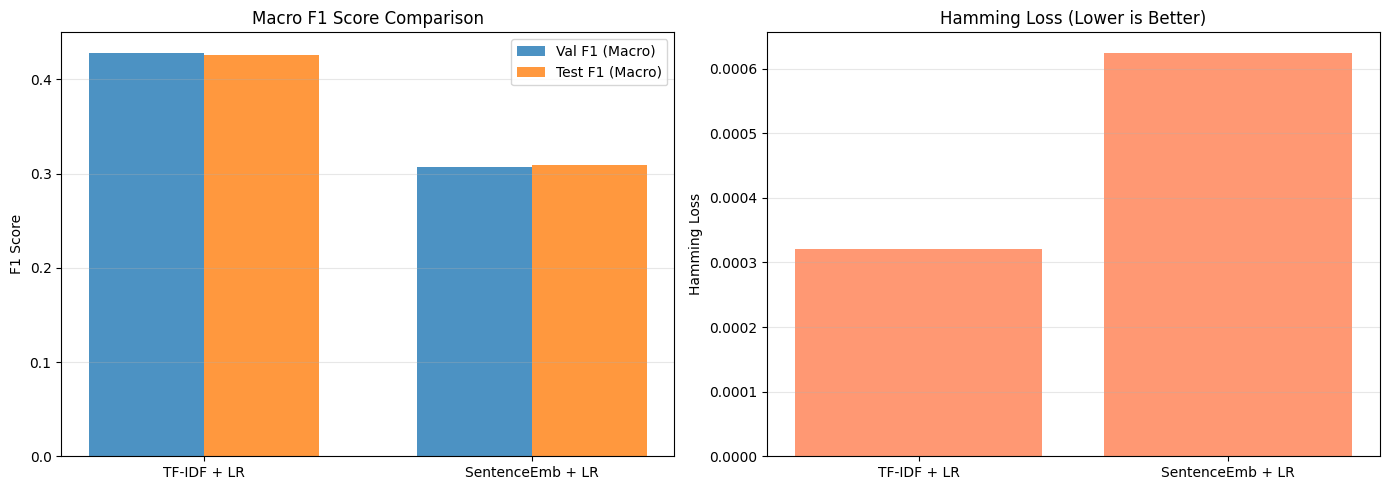

In [10]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Scores
x = np.arange(len(comparison))
width = 0.35

axes[0].bar(x - width/2, comparison['Val F1 (Macro)'], width, label='Val F1 (Macro)', alpha=0.8)
axes[0].bar(x + width/2, comparison['Test F1 (Macro)'], width, label='Test F1 (Macro)', alpha=0.8)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Macro F1 Score Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison['Model'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Hamming Loss
axes[1].bar(comparison['Model'], comparison['Hamming Loss'], color='coral', alpha=0.8)
axes[1].set_ylabel('Hamming Loss')
axes[1].set_title('Hamming Loss (Lower is Better)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Analyze Predictions

In [ ]:
# Example predictions
def show_predictions(idx, model_name, y_pred):
    """Show prediction example"""
    print(f"\n{model_name} - Example {idx}")
    print("="*70)
    print(f"Input text (first 300 chars):\n{X_test[idx][:300]}...\n")
    
    true_labels = mlb.inverse_transform(y_test[idx:idx+1])[0]
    pred_labels = mlb.inverse_transform(y_pred[idx:idx+1])[0]
    
    print(f"True conditions: {list(true_labels)}")
    print(f"Predicted conditions: {list(pred_labels)}")
    
    # Calculate overlap
    correct = set(true_labels) & set(pred_labels)
    print(f"\nCorrect predictions: {list(correct)}")
    print(f"Accuracy: {len(correct) / max(len(true_labels), 1):.2%}")

# Show a few examples
for i in range(3):
    show_predictions(i, "TF-IDF Model", y_test_pred_lr)
    show_predictions(i, "Embedding Model", y_test_pred_emb)


TF-IDF Model - Example 0
Input text (first 300 chars):
Drug Composition: Mesalazine (1200mg) Mechanism of Action: Mesalet 1200mg Tablet is an aminosalicylate. It works by suppressing the production of chemical messengers (prostaglandins) that cause inflammation (swelling) in the intestines. This reduces ulceration, bleeding and stomach pain, and prevent...

True conditions: ['Crohn’s disease', 'Ulcerative colitis']
Predicted conditions: ['Crohn’s disease', 'Ulcerative colitis']

Correct predictions: ['Crohn’s disease', 'Ulcerative colitis']
Accuracy: 100.00%

Embedding Model - Example 0
Input text (first 300 chars):
Drug Composition: Mesalazine (1200mg) Mechanism of Action: Mesalet 1200mg Tablet is an aminosalicylate. It works by suppressing the production of chemical messengers (prostaglandins) that cause inflammation (swelling) in the intestines. This reduces ulceration, bleeding and stomach pain, and prevent...

True conditions: ['Crohn’s disease', 'Ulcerative colitis']
Predicted c

## 7. Save Results

In [12]:
# Save all results
results = {
    'tfidf_val': val_results_lr,
    'tfidf_test': test_results_lr,
    'embedding_val': val_results_emb,
    'embedding_test': test_results_emb
}

with open('baseline_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save comparison table
comparison.to_csv('baseline_comparison.csv', index=False)

print("Results saved!")

Results saved!


## Summary

### Baseline Results:
- ✅ **TF-IDF + Logistic Regression**: Traditional NLP approach
- ✅ **SentenceTransformers + Classifier**: Modern embedding approach

### Key Findings:
- Sentence embeddings typically outperform TF-IDF
- Both models provide reasonable baseline performance
- Multi-label classification is challenging due to:
  - Large number of classes
  - Imbalanced class distribution
  - Multiple labels per sample

**Next Steps:** Move to Part 3 for BioBERT fine-tuning to improve performance!